In [81]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as wg
from ipywidgets import interactive, fixed

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score


import warnings
warnings.filterwarnings("ignore")

## Load data

In [2]:
df = pd.read_csv('../../data/raw/data.csv')

In [3]:
df.head(1)

,customer_id,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,1,32.0,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0


In [4]:
df = df.drop(columns='customer_id')

## EDA

In [5]:
df.head()

,age,location,subscription_type,payment_plan,num_subscription_pauses,payment_method,customer_service_inquiries,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked,churned
0,32.0,Montana,Free,Yearly,2,Paypal,Medium,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46,0
1,64.0,New Jersey,Free,Monthly,3,Paypal,Low,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37,0
2,51.0,Washington,Premium,Yearly,2,Credit Card,High,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38,0
3,63.0,California,Family,Yearly,4,Apple Pay,Medium,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24,0
4,54.0,Washington,Family,Monthly,3,Paypal,High,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   age                         125000 non-null  float64
 1   location                    125000 non-null  object 
 2   subscription_type           125000 non-null  object 
 3   payment_plan                125000 non-null  object 
 4   num_subscription_pauses     125000 non-null  int64  
 5   payment_method              125000 non-null  object 
 6   customer_service_inquiries  125000 non-null  object 
 7   signup_date                 125000 non-null  int64  
 8   weekly_hours                125000 non-null  float64
 9   average_session_length      125000 non-null  float64
 10  song_skip_rate              125000 non-null  float64
 11  weekly_songs_played         125000 non-null  int64  
 12  weekly_unique_songs         125000 non-null  int64  
 13  num_favorite_a

In [7]:
def value_counts_func(col):
    return df[col].value_counts(normalize=True)

In [8]:
cat_features = df.select_dtypes('object')
cat_features_list = cat_features.columns.tolist()

In [9]:
for i in cat_features_list:
    print(f'\n Distribuition: {value_counts_func(i)} \n ###')



 Distribuition: location
Georgia           0.063832
Idaho             0.052928
Vermont           0.052856
California        0.052720
New Jersey        0.052560
Washington        0.052536
Nebrasksa         0.052280
North Carolina    0.052184
North Dakota      0.052184
Utah              0.052056
New York          0.051944
Alabama           0.051912
Wisconsin         0.051888
Virginia          0.051736
Maine             0.051656
South Carolina    0.051600
West Virginia     0.051320
Florida           0.051200
Montana           0.050608
Name: proportion, dtype: float64 
 ###

 Distribuition: subscription_type
Premium    0.258648
Student    0.247888
Free       0.247488
Family     0.245976
Name: proportion, dtype: float64 
 ###

 Distribuition: payment_plan
Monthly    0.500496
Yearly     0.499504
Name: proportion, dtype: float64 
 ###

 Distribuition: payment_method
Debit Card     0.250336
Paypal         0.250256
Credit Card    0.249704
Apple Pay      0.249704
Name: proportion, dtype: float6

In [10]:
cat_features.sample(5)

,location,subscription_type,payment_plan,payment_method,customer_service_inquiries
62608,Washington,Premium,Yearly,Credit Card,High
23111,New York,Free,Yearly,Paypal,Medium
86380,South Carolina,Student,Yearly,Credit Card,Low
119658,Nebrasksa,Student,Monthly,Apple Pay,High
92666,Vermont,Free,Monthly,Credit Card,Medium


In [11]:
num_features = df.select_dtypes('number')
num_features = num_features.drop(columns='churned')

In [12]:
num_features.sample(5)

,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked
72789,60.0,4,-129,0.000068,84.395521,0.077218,337,295,11,118,81,47,26
7872,28.0,1,-2890,27.181237,7.235950,0.073620,453,14,17,20,98,28,21
105212,47.0,3,-1610,0.427059,35.609146,0.847154,471,226,38,122,77,15,2
18898,77.0,2,-1746,15.311148,7.730530,0.678657,398,280,29,128,66,48,6
70670,32.0,4,-2582,0.208084,85.607736,0.834390,104,246,44,47,16,10,10


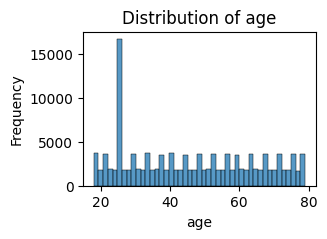

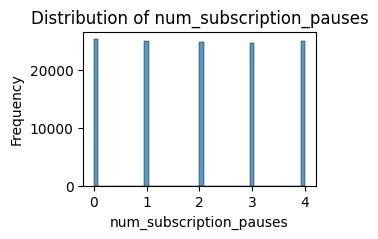

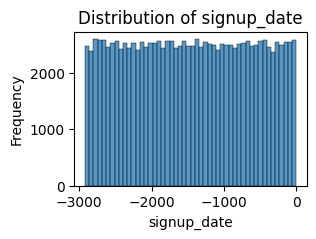

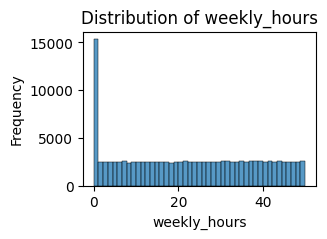

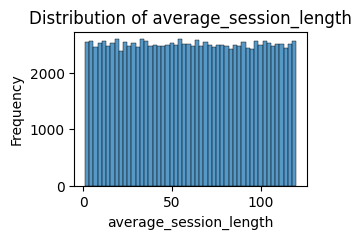

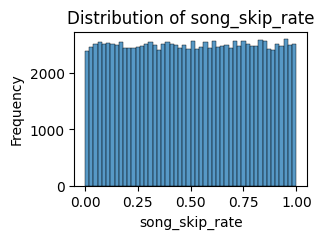

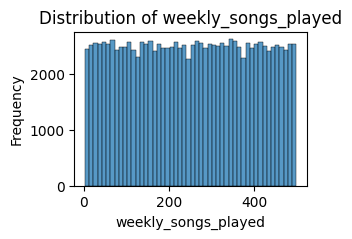

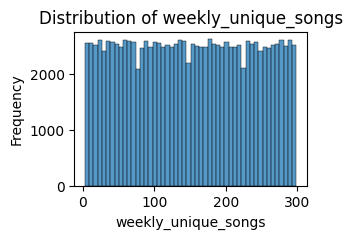

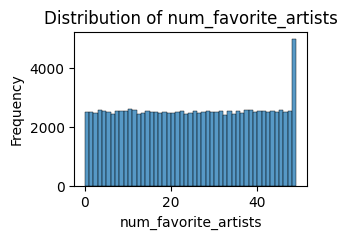

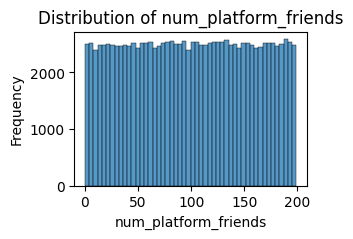

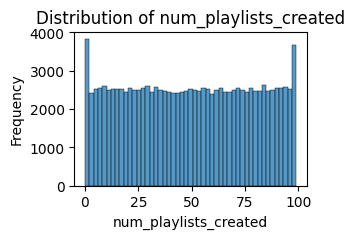

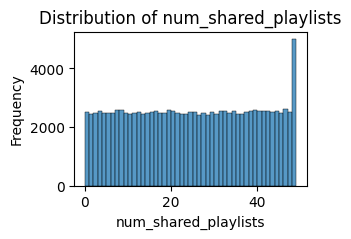

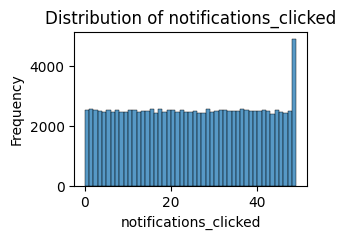

In [13]:
for col in num_features.columns.tolist():
    plt.figure(figsize=(3, 2))
    sns.histplot(data=num_features[col])
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.show()

Okay, there's no distribution

## Numerical data: standardizing

#### Approach 01 (NOT WORKING)

In [14]:
def q_describe(column):
    quantiles = [
        num_features[column].quantile(0.25),
        num_features[column].quantile(0.5),
        num_features[column].quantile(0.75),
        num_features[column].quantile(1)
    ]
    
    return quantiles    

In [15]:
for i in num_features.columns.tolist():
    print(f'{i}: {q_describe(i)}')

age: [np.float64(28.0), np.float64(45.0), np.float64(62.0), np.float64(79.0)]
num_subscription_pauses: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0)]
signup_date: [np.float64(-2190.0), np.float64(-1462.0), np.float64(-728.0), np.float64(-1.0)]
weekly_hours: [np.float64(8.181201492), np.float64(22.199458605), np.float64(36.18626506), np.float64(49.99994331)]
average_session_length: [np.float64(30.64417674), np.float64(60.340976805), np.float64(90.23415847000001), np.float64(119.9965006)]
song_skip_rate: [np.float64(0.25097435975000004), np.float64(0.5011623175), np.float64(0.7511096105), np.float64(0.99997002)]
weekly_songs_played: [np.float64(127.0), np.float64(251.0), np.float64(375.0), np.float64(499.0)]
weekly_unique_songs: [np.float64(76.0), np.float64(150.0), np.float64(225.0), np.float64(299.0)]
num_favorite_artists: [np.float64(12.0), np.float64(25.0), np.float64(37.0), np.float64(49.0)]
num_platform_friends: [np.float64(50.0), np.float64(100.0), np.float64

In [16]:
quantile_data = []

for col in num_features.columns.tolist():
    quantile = q_describe(col)
    quantile_data.append([col] + quantile)

df_quantiles = pd.DataFrame(quantile_data, columns=['Feature', '25p', '50p', '75p', 'Max'])
df_quantiles

,Feature,25p,50p,75p,Max
0,age,28.000000,45.000000,62.000000,79.000000
1,num_subscription_pauses,1.000000,2.000000,3.000000,4.000000
2,signup_date,-2190.000000,-1462.000000,-728.000000,-1.000000
3,weekly_hours,8.181201,22.199459,36.186265,49.999943
4,average_session_length,30.644177,60.340977,90.234158,119.996501
5,song_skip_rate,0.250974,0.501162,0.751110,0.999970
6,weekly_songs_played,127.000000,251.000000,375.000000,499.000000
7,weekly_unique_songs,76.000000,150.000000,225.000000,299.000000
8,num_favorite_artists,12.000000,25.000000,37.000000,49.000000
9,num_platform_friends,50.000000,100.000000,150.000000,199.000000


In [17]:
def flag(value, quantiles):
    if value <= quantiles[0]:
        return 1
    elif value <= quantiles[1]:
        return 2
    elif value <= quantiles[2]:
        return 3
    else:
        return 4

In [18]:
for col in num_features.columns.tolist():
    quantiles = [
        num_features[col].quantile(0.25),
        num_features[col].quantile(0.5),
        num_features[col].quantile(0.75)
    ]
    num_features[f'{col}_flag'] = num_features[col].apply(lambda x: flag(x, quantiles))

In [19]:
num_features.head(3)

,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,...,weekly_hours_flag,average_session_length_flag,song_skip_rate_flag,weekly_songs_played_flag,weekly_unique_songs_flag,num_favorite_artists_flag,num_platform_friends_flag,num_playlists_created_flag,num_shared_playlists_flag,notifications_clicked_flag
0,32.0,2,-1606,22.391362,105.394516,0.176873,169,109,18,32,...,3,4,1,2,2,2,1,3,3,4
1,64.0,3,-2897,29.294210,52.501115,0.981811,55,163,44,33,...,3,2,4,1,3,4,1,1,2,3
2,51.0,2,-348,15.400312,24.703696,0.048411,244,117,20,129,...,2,1,1,2,2,2,3,3,3,4


In [20]:
num_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   age                           125000 non-null  float64
 1   num_subscription_pauses       125000 non-null  int64  
 2   signup_date                   125000 non-null  int64  
 3   weekly_hours                  125000 non-null  float64
 4   average_session_length        125000 non-null  float64
 5   song_skip_rate                125000 non-null  float64
 6   weekly_songs_played           125000 non-null  int64  
 7   weekly_unique_songs           125000 non-null  int64  
 8   num_favorite_artists          125000 non-null  int64  
 9   num_platform_friends          125000 non-null  int64  
 10  num_playlists_created         125000 non-null  int64  
 11  num_shared_playlists          125000 non-null  int64  
 12  notifications_clicked         125000 non-nul

In [21]:
num_flag = num_features[num_features.columns.tolist()[13:24]]

In [22]:
num_flag

,age_flag,num_subscription_pauses_flag,signup_date_flag,weekly_hours_flag,average_session_length_flag,song_skip_rate_flag,weekly_songs_played_flag,weekly_unique_songs_flag,num_favorite_artists_flag,num_platform_friends_flag,num_playlists_created_flag
0,2,2,2,3,4,1,2,2,2,1,3
1,4,3,1,3,2,4,1,3,4,1,1
2,3,2,4,2,1,1,2,2,2,3,3
3,4,4,1,3,3,1,4,4,4,3,3
4,3,3,4,3,2,1,2,4,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
124995,2,4,2,3,1,4,4,1,2,4,3
124996,1,2,1,4,4,3,3,1,4,4,3
124997,2,1,4,2,3,2,1,3,4,1,4
124998,4,4,1,3,1,1,4,2,2,1,1


#### Approach 02

In [14]:
num_features

,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked
0,32.0,2,-1606,22.391362,105.394516,0.176873,169,109,18,32,52,35,46
1,64.0,3,-2897,29.294210,52.501115,0.981811,55,163,44,33,12,25,37
2,51.0,2,-348,15.400312,24.703696,0.048411,244,117,20,129,50,28,38
3,63.0,4,-2894,22.842084,83.595480,0.035691,442,252,47,120,55,17,24
4,54.0,3,-92,23.151163,52.578266,0.039738,243,230,41,66,40,32,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124995,32.0,4,-1895,29.161399,7.176704,0.893839,460,22,18,199,71,41,41
124996,26.0,2,-2778,44.744198,105.069363,0.668759,315,16,48,185,67,23,30
124997,45.0,0,-604,15.200073,78.064000,0.286604,11,206,48,40,78,40,28
124998,69.0,4,-2570,35.270053,20.921062,0.092528,451,108,15,41,3,35,9


In [15]:
scaler = StandardScaler()
num_scaled = scaler.fit_transform(num_features)

In [16]:
num_scaled

array([[-0.77211509,  0.00624896, -0.17215494, ...,  0.08784985,
         0.72265275,  1.49438137],
       [ 0.97934127,  0.71186818, -1.70154114, ..., -1.29454998,
         0.03083938,  0.87036905],
       [ 0.26781213,  0.00624896,  1.31813773, ...,  0.01872986,
         0.23838339,  0.93970376],
       ...,
       [-0.06058594, -1.40498947,  1.01486673, ...,  0.98640974,
         1.06855944,  0.24635674],
       [ 1.25300633,  1.41748739, -1.31415982, ..., -1.60558994,
         0.72265275, -1.0710026 ],
       [-1.53837724,  1.41748739, -0.56072092, ...,  0.95184974,
         0.16920205, -1.55634552]])

In [17]:
df_numerical_scaled = pd.DataFrame(num_scaled, columns=scaler.get_feature_names_out())

## Categorical features: standardizing

In [18]:
cat_features

,location,subscription_type,payment_plan,payment_method,customer_service_inquiries
0,Montana,Free,Yearly,Paypal,Medium
1,New Jersey,Free,Monthly,Paypal,Low
2,Washington,Premium,Yearly,Credit Card,High
3,California,Family,Yearly,Apple Pay,Medium
4,Washington,Family,Monthly,Paypal,High
...,...,...,...,...,...
124995,California,Student,Monthly,Debit Card,Low
124996,Maine,Premium,Yearly,Debit Card,Low
124997,Maine,Family,Monthly,Paypal,Medium
124998,Maine,Free,Monthly,Paypal,High


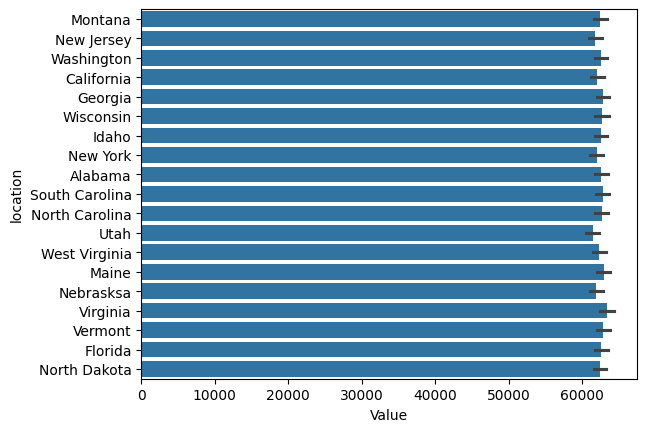

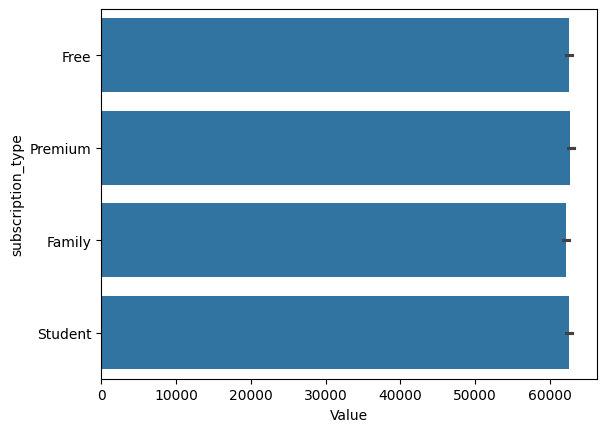

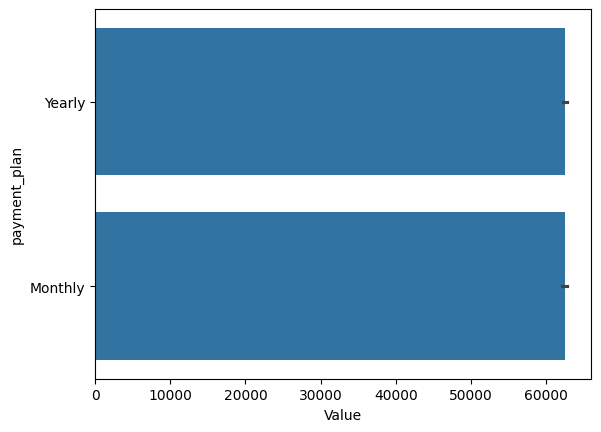

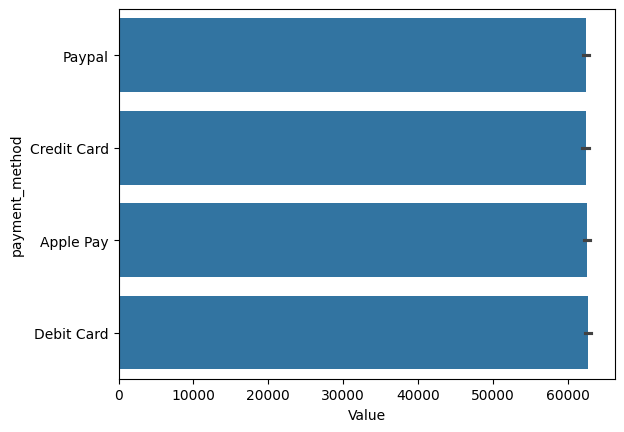

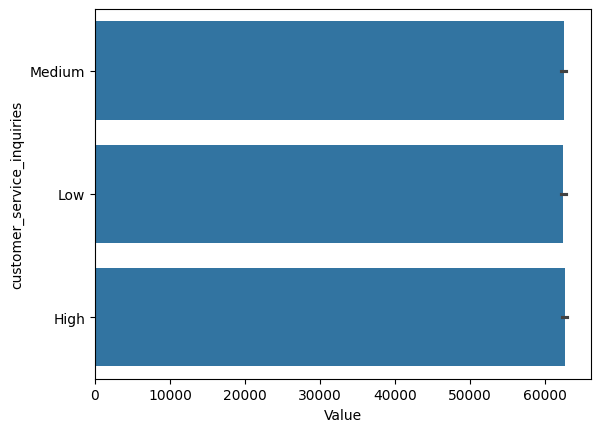

In [19]:
for f in cat_features.columns.tolist():
    plt.figure()
    sns.barplot(data=cat_features[f])
    plt.ylabel(f)
    plt.xlabel('Value')
    plt.show()

#### Preprocessing

In [20]:
ordinal_features = ['subscription_type', 'payment_plan',
                    'customer_service_inquiries']

non_ordinal_features = ['payment_method']

In [21]:
ord_transformer = Pipeline(steps=[
    ('label_encoder', OrdinalEncoder())
])

non_ord_transformer = Pipeline(steps=[
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [22]:
preprocessor = ColumnTransformer(transformers=[
    ('ord', ord_transformer, ordinal_features),
    ('non-ord', non_ord_transformer, non_ordinal_features)
])

cat_encoded = preprocessor.fit_transform(cat_features)

In [23]:
df_cat_encoded = pd.DataFrame(cat_encoded, columns=preprocessor.get_feature_names_out())

In [24]:
df_cat_encoded

,ord__subscription_type,ord__payment_plan,ord__customer_service_inquiries,non-ord__payment_method_Apple Pay,non-ord__payment_method_Credit Card,non-ord__payment_method_Debit Card,non-ord__payment_method_Paypal
0,1.0,1.0,2.0,0.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,2.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
124995,3.0,0.0,1.0,0.0,0.0,1.0,0.0
124996,2.0,1.0,1.0,0.0,0.0,1.0,0.0
124997,0.0,0.0,2.0,0.0,0.0,0.0,1.0
124998,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Next steps:

1. Verify Ordinal Encode process;
2. Concat all.

### Concat

In [25]:
df_std = pd.concat([df_cat_encoded.reset_index(drop=True), df_numerical_scaled.reset_index(drop=True)], axis=1)

In [26]:
df_std.sample(5)

,ord__subscription_type,ord__payment_plan,ord__customer_service_inquiries,non-ord__payment_method_Apple Pay,non-ord__payment_method_Credit Card,non-ord__payment_method_Debit Card,non-ord__payment_method_Paypal,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked
114651,2.0,0.0,1.0,0.0,0.0,0.0,1.0,0.486744,-1.404989,1.396325,-1.111728,-0.284272,0.613342,0.175655,0.923329,-1.003736,-1.520657,0.74449,1.483647,0.939704
56084,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.158346,0.711868,0.216411,0.153922,0.426781,-1.664073,0.615209,0.911673,0.726857,-1.364627,-0.98351,-0.937699,0.801034
47335,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.048880,-0.699370,1.423572,-1.434715,-0.707869,-0.567181,1.305937,0.165706,-0.726841,-0.861863,-1.15631,1.276103,-1.348341
58965,3.0,1.0,2.0,1.0,0.0,0.0,0.0,-1.319445,1.417487,0.366862,1.714606,-1.319065,-0.042483,-0.717408,-1.431131,0.519185,0.941153,-0.98351,-1.491150,-0.100317
70121,2.0,1.0,1.0,0.0,0.0,1.0,0.0,-1.100513,0.711868,-0.839114,-0.881458,-0.229295,-1.646830,0.273333,0.608624,-0.588394,-0.168395,-0.91439,0.722653,1.078373


## Classification

In [29]:
df_std.sample(3)

,ord__subscription_type,ord__payment_plan,ord__customer_service_inquiries,non-ord__payment_method_Apple Pay,non-ord__payment_method_Credit Card,non-ord__payment_method_Debit Card,non-ord__payment_method_Paypal,age,num_subscription_pauses,signup_date,weekly_hours,average_session_length,song_skip_rate,weekly_songs_played,weekly_unique_songs,num_favorite_artists,num_platform_friends,num_playlists_created,num_shared_playlists,notifications_clicked
36529,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.307739,0.711868,-0.033551,-1.434715,-0.779774,-0.748885,-0.138313,0.154050,0.449962,-1.555331,-0.98351,0.584290,1.147708
47012,3.0,1.0,2.0,0.0,1.0,0.0,0.0,-1.538377,1.417487,-0.818975,1.757572,0.964026,1.406304,-1.449998,-1.209672,-0.103828,-1.416637,1.02097,0.791834,1.702385
16686,3.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.100513,-1.404989,0.094392,0.088551,-1.033506,-0.306737,-0.982536,1.261346,-0.449946,1.374570,-1.43279,0.515109,0.939704


In [30]:
X, y = df_std, df['churned']

In [31]:
X.isna().sum()

ord__subscription_type                 0
ord__payment_plan                      0
ord__customer_service_inquiries        0
non-ord__payment_method_Apple Pay      0
non-ord__payment_method_Credit Card    0
non-ord__payment_method_Debit Card     0
non-ord__payment_method_Paypal         0
age                                    0
num_subscription_pauses                0
signup_date                            0
weekly_hours                           0
average_session_length                 0
song_skip_rate                         0
weekly_songs_played                    0
weekly_unique_songs                    0
num_favorite_artists                   0
num_platform_friends                   0
num_playlists_created                  0
num_shared_playlists                   0
notifications_clicked                  0
dtype: int64

In [32]:
y.isna().sum()

np.int64(0)

In [33]:
y.value_counts(normalize=True)

churned
0    0.9
1    0.1
Name: proportion, dtype: float64

### Let the model go

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

In [95]:
rf_model = RandomForestClassifier(
    max_depth=1,
    n_estimators=50,
    ccp_alpha=1,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [96]:
print('\n Classification Report: \n\n {}'.format(classification_report(y_test, y_pred)))
print('\n Confusion Matrix: \n\n {}'.format(confusion_matrix(y_test, y_pred)))
print('\n F1 Score: \n\n {}'.format(f1_score(y_test, y_pred)))
print('\n ROC-AUC Score: \n\n {}:'.format(roc_auc_score(y_test, y_proba)))


 Classification Report: 

               precision    recall  f1-score   support

           0       0.90      1.00      0.95     22570
           1       0.00      0.00      0.00      2430

    accuracy                           0.90     25000
   macro avg       0.45      0.50      0.47     25000
weighted avg       0.82      0.90      0.86     25000


 Confusion Matrix: 

 [[22570     0]
 [ 2430     0]]

 F1 Score: 

 0.0

 ROC-AUC Score: 

 0.5:


### Holding it...

In [97]:
df = pd.concat([X, y], axis=1)

class_0 = df[df['churned'] == 0]
class_1 = df[df['churned'] == 1]

class_0_downsampled = resample(class_0, 
                               replace=False, 
                               n_samples=len(class_1), 
                               random_state=42)

balanced_df = pd.concat([class_0_downsampled, class_1])

X_balanced = balanced_df.drop(columns=['churned'])
y_balanced = balanced_df['churned']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,
                                                    y_balanced,
                                                    test_size=0.2,
                                                    random_state=42)

In [99]:
rf_model = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    random_state=42
)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

In [100]:
print('\n Classification Report: \n\n {}'.format(classification_report(y_test, y_pred)))
print('\n Confusion Matrix: \n\n {}'.format(confusion_matrix(y_test, y_pred)))
print('\n F1 Score: \n\n {}'.format(f1_score(y_test, y_pred)))
print('\n ROC-AUC Score: \n\n {}:'.format(roc_auc_score(y_test, y_proba)))


 Classification Report: 

               precision    recall  f1-score   support

           0       0.52      0.50      0.51      2515
           1       0.51      0.53      0.52      2485

    accuracy                           0.52      5000
   macro avg       0.52      0.52      0.52      5000
weighted avg       0.52      0.52      0.52      5000


 Confusion Matrix: 

 [[1249 1266]
 [1158 1327]]

 F1 Score: 

 0.5226467113036629

 ROC-AUC Score: 

 0.5214058106091819:


### Feature Importance

In [101]:
feature_importance = pd.DataFrame({'features': df_std.columns.tolist(), 'percent': rf_model.feature_importances_*100})

In [102]:
feature_importance.sort_values(by='percent', ascending=False)

,features,percent
9,signup_date,8.909160
11,average_session_length,8.623593
12,song_skip_rate,8.584061
14,weekly_unique_songs,8.092771
13,weekly_songs_played,7.971604
10,weekly_hours,7.940084
16,num_platform_friends,7.663238
17,num_playlists_created,7.044291
15,num_favorite_artists,6.316125
18,num_shared_playlists,6.313747
